Machinery for manufacturing LIBS type spectra

TODO: class docstrings AND Type Hints per:
https://realpython.com/documenting-python-code/
https://docs.python.org/3/library/typing.html

In [1]:
#imports and env
import numpy as np
import pickle
import math
from matplotlib import pyplot as plt
#from scipy.special import voigt_profile as voigt
#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker2 import spectrum_maker
from pathlib import Path

top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path

/Users/matt/CloudGit_local/github/gss/phaseMAP/envs/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#import ordered list of 80 elements for this nist dataset
elem_symb = np.genfromtxt(datapath / 'nist_libs' / 'elem_symb.csv', dtype=str)
max_z = len(elem_symb)
el_index = {} #lookup from el symb to array index of element
ind = 0
for el in elem_symb:
    el_index[el] = ind
    ind += 1
el_count = len(elem_symb)

In [3]:
#create a dataset with fixed proportions on element pairs from 80 elements
spec_maker = spectrum_maker()
n_samples = 9560 #80 pure + 80 choose 2 with 3 mix ratios for each unique pair
fracs = np.zeros((n_samples,el_count)) #these will be intended element mixes for samples
frac_count = 0
#add pure element instances
for i in range(el_count):
    fracs[frac_count,i] = 1
    frac_count += 1
#now add combinations
for i in range(el_count - 1): #Very last element has nothing ahead to pair with
    for j in range(i+1, el_count): #new pairs start at next element and goto last
        fracs[frac_count,i] = 0.9
        fracs[frac_count,j] = 0.1
        frac_count += 1
        fracs[frac_count,i] = 0.5
        fracs[frac_count,j] = 0.5
        frac_count += 1
        fracs[frac_count,i] = 0.1
        fracs[frac_count,j] = 0.9
        frac_count += 1


In [4]:
#importing just to get wave object associated with this dataset
with open(datapath / 'nist_libs' / 'nist_elem_libs.pickle', 'rb') as f:
    wave = pickle.load(f)

In [6]:
#construct 9560 sample data set to persist for training
#x_data will hold the composite spectrum as from LIBS
#y_data will hold the elemental spectra made from weighting atomic lines
#note that x_data != weighted sum of y_data (confirm)
x_data = np.zeros((n_samples, len(wave))) #model inputs, composite spectrum
y_data = np.zeros((n_samples, max_z + 2, len(wave))) #outputs, weighted spectra + art + noise

for i in np.arange(n_samples):
    # create input dict from fracs array
    fracs_dict = {}
    sample_el = elem_symb[np.nonzero(fracs[i])]
    for el in sample_el:
        fracs_dict[el] = fracs[i][el_index[el]]
    wave, spec_dict, lines_dict = spec_maker.make_spectra(fracs_dict)
    for el in spec_dict.keys():
        if el == 'comp':
            x_data[i] = spec_dict['comp']
        elif el == 'art':
            y_data[max_z] = spec_dict['art']
        elif el == 'noi':
            y_data[max_z + 1] = spec_dict['noi']
        else:
            y_data[i][el_index[el]] = spec_dict[el]

<function matplotlib.pyplot.show(close=None, block=None)>

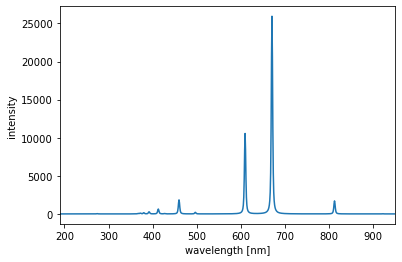

In [7]:
#Inspect combinations / compositions

plt.plot(wave, x_data[el_index['Li']]) 
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [8]:
#persist sample data and provide code to reload elsewhere
#with open(datapath / 'training' / 'el80_pairs.pickle', 'wb') as f:
#    pickle.dump(elem_symb, f)
#    pickle.dump(el_index, f)
#    pickle.dump(fracs, f)
#    pickle.dump(wave, f)
#    pickle.dump(x_data, f)
#    pickle.dump(y_data, f)


#To load in other modules
#with open(datapath / 'training' / 'el80_pairs.pickle', 'rb') as f:
#   elem_symb = pickle.load(f)
#   el_index = pickle.load(f)
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#   y_data = pickle.load(f)



In [10]:
#make a metadata pickle for use with prediction
#with open(datapath / 'training' / 'el80_pairs_meta.pickle', 'wb') as f:
#    pickle.dump(wave, f)
#    pickle.dump(elem_symb, f)
#    pickle.dump(el_index, f)

#To load in other modules
#with open(datapath / 'training' / 'el80_pairs_meta.pickle', 'rb') as f:
#    wave = pickle.load(f)
#    elem_symb = pickle.load(f)
#    el_index = pickle.load(f) """